## Import modules and functions

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import glob
import re
import os

import pylab as pl
import matplotlib
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from scipy.signal import savgol_filter

from matplotlib.gridspec    import GridSpec
import import_ipynb

import Module_Diagnostics as MD
import numpy as np
from tempfile import mkdtemp
import os.path as path
import sys

from pathlib import Path
import json

#Debugger. For some reason, using it inside a function works well. Otherwise...
from IPython.core.debugger import set_trace
#exemple: 
# def debug():
#     set_trace()
    
#     `code_to_debug`
    
#     return

# debug()

In /home/clement/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/clement/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/clement/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/clement/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/clement/.local/lib/python3.6/site-packages/matplotlib/mpl-d

importing Jupyter notebook from Module_Diagnostics.ipynb
testing compute_RMS(...):
This should be close to 1: 0.9871849213736911
This should be close to 0: 0.0


## Choose run

In [11]:
run_name = 'RUN_NAME'

### Only if working on lx-moissard
Cluster = 'Occ/'
run_name = '20_08_18_new_big_one_0'
filepath = '/data/Lathys/Visualisation/' + Cluster + run_name + '/ncfiles/'
filepath = '../ncfiles/'
filepath = '../' + Cluster + run_name + '/ncfiles/'

#This is used by the functions find_ip_shock(N, V) and find_mc_leading_edge(B)
metadata = {'t_shock_entrance' : 130,
            't_shock_exit'     : 240,
            't_MC_entrance'    : 130,
            't_MC_exit'        : 270}
#todo: autodefine t_collision? maybe from story_reader will be easier, as lines will cross on the multivariate plot

t_collision = None #default
t_collision = 216.5 #if known

from_time = 210
to_time = 220 #metadata['t_shock_exit']

#date = re.search('Magw_(.+?)_t', glob.glob(filepath+'Magw*_t'+ '%05d' % from_time +'.nc')[0]).group(1) 
date = "18_08_20"

print(f'date of the simulation (DD_MM_YY): {date}')

date of the simulation (DD_MM_YY): 18_08_20


In [14]:
storing_directory_json = filepath + "../shock_tracking/"
#The next line links directly to my PhD_Manuscript on Overleaf.com
#Saving plots there means that I do not need to worry about having the very last version before
#starting to write about it in Overleaf, since it will always be up to date.
dropbox = os.environ['DROPBOX']
dropbox_dir = storing_directory_json #dropbox + "/Apps/Overleaf/PhD_Manuscript/Images/LATHYS"

path_store_json = Path(storing_directory_json)

if not(path_store_json.exists()):
    os.system(f'mkdir {path_store_json}')

# name = "shock_tracking_" + run_name + ".json"
# name = "shock_tracking_occ.json"
name = "shock_tracking_for_Article_Part_I20_08_18_new_big_one_0.json"

path_json = Path(storing_directory_json + name)

In [15]:
with open(path_json, "r", encoding='utf-8') as shock_tracking:
            stored_data = json.load(shock_tracking)

In [16]:
stored_data.keys()

dict_keys(['00210', 'x', 'y', 'z', '00211'])

In [17]:
stored_data['00210'].keys()

dict_keys(['Vx', 'Vy', 'Vz'])

In [18]:
stored_data['00210']['Vx'].keys()

dict_keys(['(xy) plane', '(xz) plane'])

In [19]:
stored_data['00210']['Vx']['(xy) plane'].keys()

dict_keys(['y = -300.0', 'y = -100.0', 'y = -95.0', 'y = -90.0', 'y = -85.0', 'y = -80.0', 'y = -75.0', 'y = -70.0', 'y = -0.0', 'y = 70.0', 'y = 75.0', 'y = 80.0', 'y = 85.0', 'y = 90.0', 'y = 95.0', 'y = 100.0', 'y = 300.0'])

## Def functions

In [20]:
x = np.array(stored_data['x'])
y = np.array(stored_data['y'])
z = np.array(stored_data['z'])

In [21]:
from scipy import signal
from collections.abc import Iterable

def simplified_find_ip_shock(V, test=None, first_point=False, verbose=False):
    
    Vx, Vy, Vz = tuple(V)    

    v_slice = np.sqrt( np.array(Vx)**2
                      +np.array(Vy)**2
                      +np.array(Vz)**2 ) 
    grad_v = np.gradient(v_slice)
    
    #Be careful, this test is very arbitrary. Works for the dataset I'm using.
    large_grad_v = [True if (grad_v[i] > 100*np.nanmean(grad_v)) else False for i in range(0,len(grad_v))]
    
    if not(test):
        test = large_grad_v
        
    if test:
        test = np.array(test) * np.array(large_grad_v)
                     
    ix_is = first_largest(grad_v, grad_v[test], verbose=verbose)   
    if np.isnan(ix_is):
        return np.nan
    x_is = x[ix_is]    
    
    if isinstance(x_is, Iterable):
        x_is = x_is[0]
        
    print("grad_v[ix_is] = ", grad_v[ix_is])

    return x_is

def simplified_check_for_absurdities(list_pos, V, first_estimation=None, verbose=False, info=None):
   
    maximum_expected_change = 13
    minimum_expected_change = 2
    
    if info=='slow':
        maximum_expected_change = 8
    
    if first_estimation:
        prev_position = first_estimation
        maximum_expected_change = 20
        minimum_expected_change = 0
    else:
        prev_position = list_pos[-2]
        
    position = list_pos[-1]
    
    absurd = False
    test = np.ones(len(V))*True
    if ( abs(prev_position - position) > maximum_expected_change or 
         abs(position - prev_position) < minimum_expected_change or
         position > prev_position ) :
        absurd = True
        if verbose:
            print(f'''This is absurd, the ip shock was located at {prev_position} 
                      and now it would be at {position}!''')
        test = [True if (prev_position - maximum_expected_change 
                         <  x[i]  < 
                         prev_position - minimum_expected_change) else False for i in range(0, len(V[0]))]
    else:
        if verbose:
            print("Sounds like a good position for the ip shock")

    return {'absurd': absurd, 'test': test, 'prev_position': prev_position, 'position': position}


def first_largest(list1, sub_list1, verbose=False):
    '''
    This function extracts the three largest local maxima 
    from sub_list1.
    Then, it finds the one with the smallest x
    '''
    tmp = list(sub_list1.copy())
    three_largest = []
        
    try:
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        c1 = x[np.where(list1 == three_largest[0])][0]
    except ValueError:
        return np.nan    
    if all(np.isnan(tmp)) or not(tmp):
        candidates = [c1]
       
    c2_ok = False
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
    #at this point, we have the two largest local maximas
        c2 = x[np.where(list1 == three_largest[1])][0]
        c2_ok = True
        
    if tmp and not(all(np.isnan(tmp))):
        three_largest.extend([tmp.pop(tmp.index(np.nanmax(tmp)))])
        #at this point, we have the three largest local maximas    
        c3 = x[np.where(list1 == three_largest[2])][0]
        candidates = [c1, c2, c3]
    elif c2_ok:
        candidates = [c1, c2]

    index_first = candidates.index(min(candidates))
    index_first = MD.aplatir(np.where(x == candidates[index_first]))
    #Which of the two candidate has the smallest x
    
    if verbose:
        print(f'the chosen candidate for the position of the ip shock is {x[index_first]}')
    
    return index_first

## Trace Shock

In [22]:
verbose = True
rcParams["figure.figsize"] = [17, 8]

time = 00210
grad_v[ix_is] =  122.2272002637232
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  136.5208844096146
first try x_is = 101.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
time = 00210
grad_v[ix_is] =  141.8611136706432
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  139.66234899305107
first try x_is = 100.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
time = 00210
grad_v[ix_is] =  141.12918471715446
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  128.61890849482785
first try x_is = 100.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
time = 00210
grad_v[ix_is] =  124.7500900236046
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  99.35478443644442
first try x_is = 100.0
Sounds like a good position for t

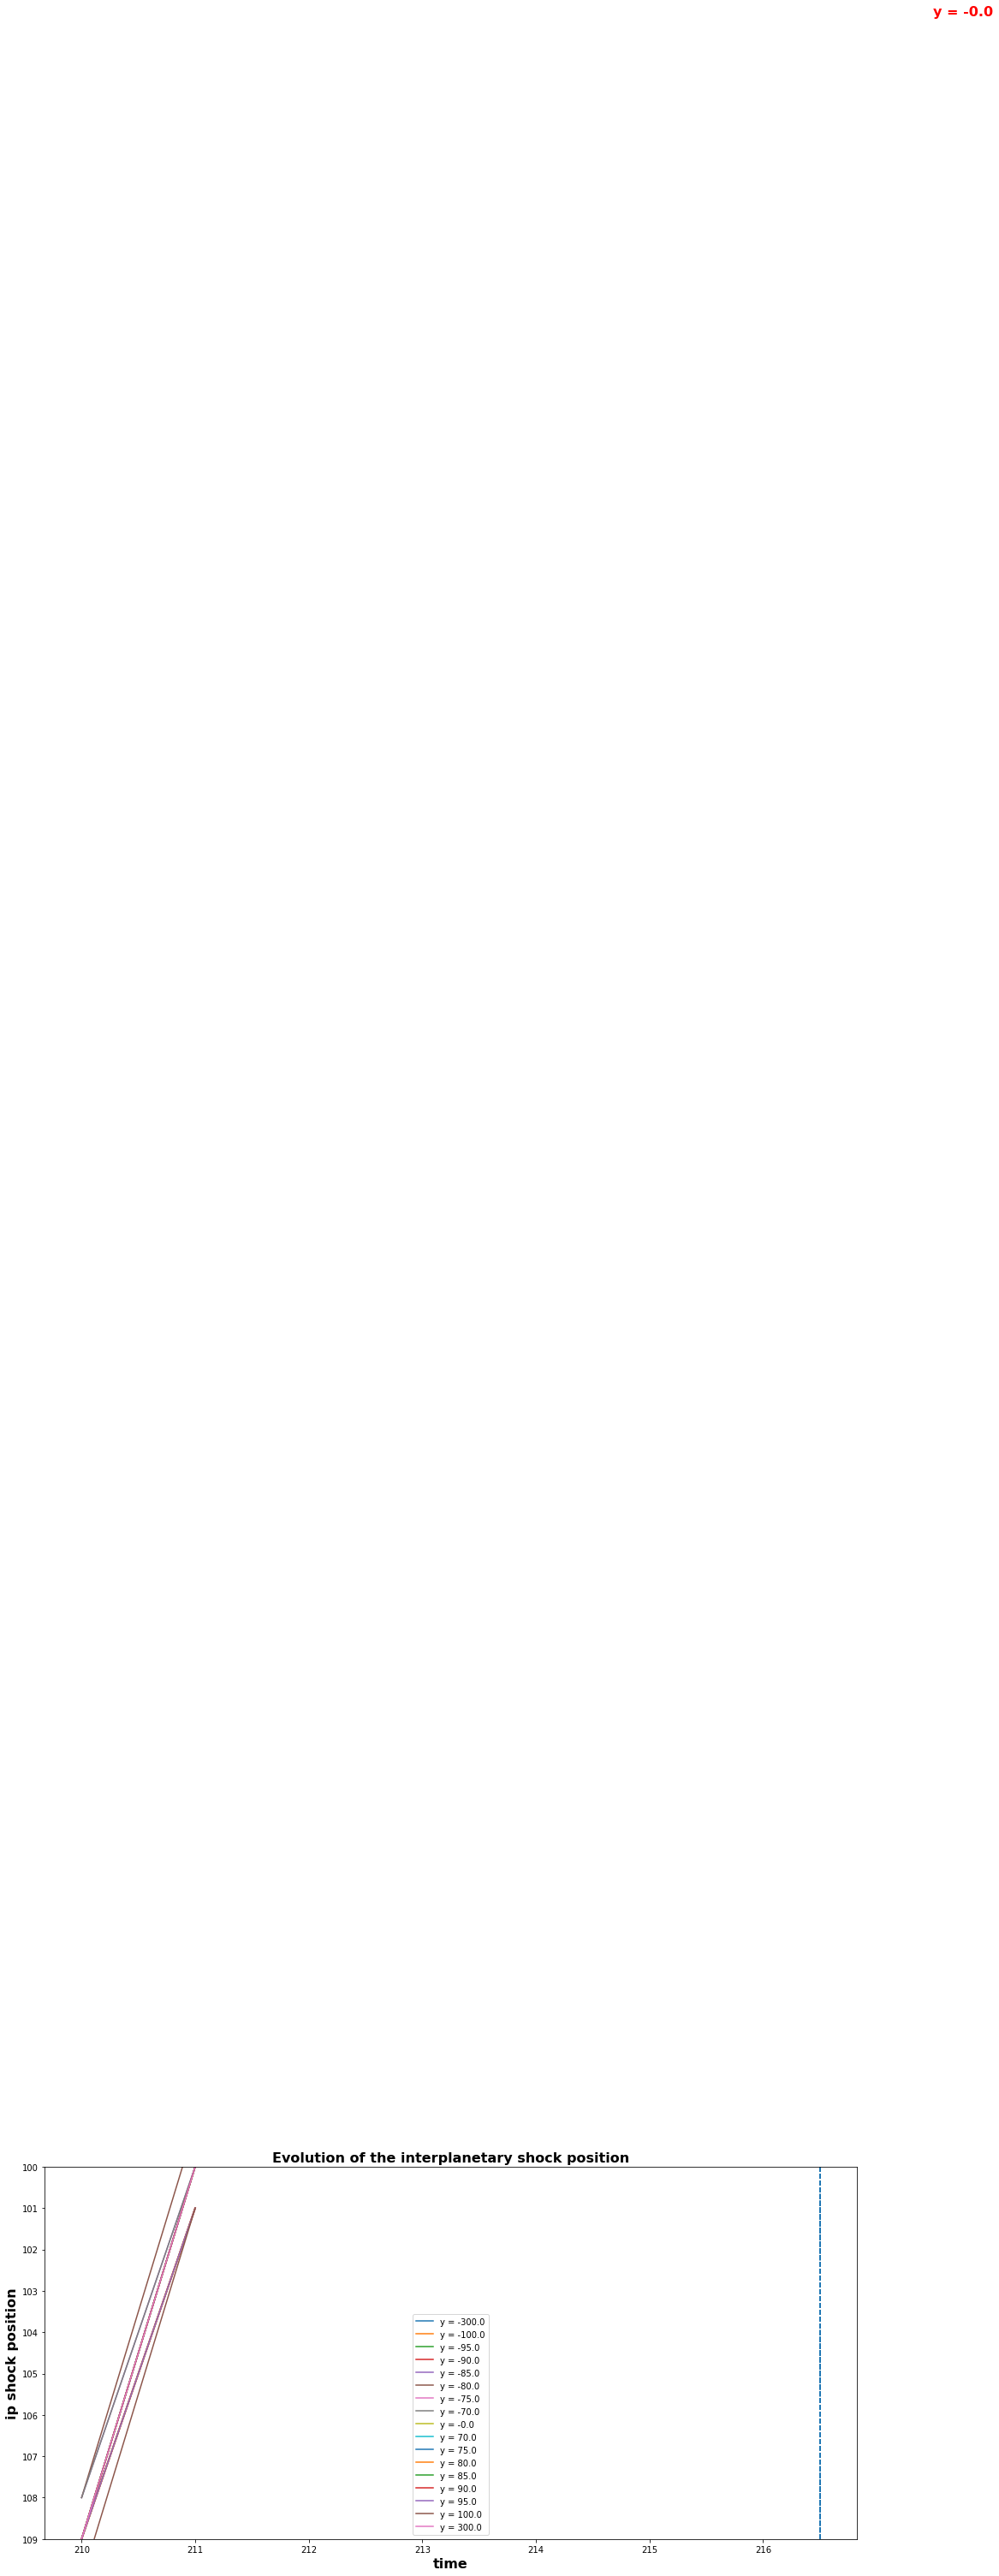

In [23]:
for y_slice in stored_data['00210']['Vx']['(xy) plane'].keys():

  
    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()) or int(time)>=235:
            continue
  
            
        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (y_slice == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xy[y_slice]
        Vy = Vy_xy[y_slice]
        Vz = Vz_xy[y_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

                    
    if y_slice == 'y = -0.0':
        t_fig_y0 = t[:-2]
        pos_fig_y0 = pos[:-2]
    if y_slice == 'y = 90.0':
        t_fig_y = t[:-1]
        pos_fig_y = pos[:-1]
    if y_slice == 'y = -300.0':
        t_ref = t[:-1]
        pos_ref = pos[:-1]
        
        
    plt.plot(t, pos, label=y_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(216.5, linestyle='--', )
    
    if y_slice == 'y = -0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xy"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

z = -300.0
time = 00210
grad_v[ix_is] =  130.6237194755408
first try x_is = 109.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  103.0921555379258
first try x_is = 100.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
z = -100.0
time = 00210
grad_v[ix_is] =  98.28148265825601
first try x_is = 108.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  143.25972904334373
first try x_is = 100.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
z = -95.0
time = 00210
grad_v[ix_is] =  101.90597891643631
first try x_is = 108.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  145.80702924589417
first try x_is = 100.0
Sounds like a good position for the ip shock
time = x
time = y
time = z
z = -90.0
time = 00210
grad_v[ix_is] =  77.65489250694341
first try x_is = 108.0
Sounds like a good position for the ip shock
time = 00211
grad_v[ix_is] =  141.09443849081913
first try x_i

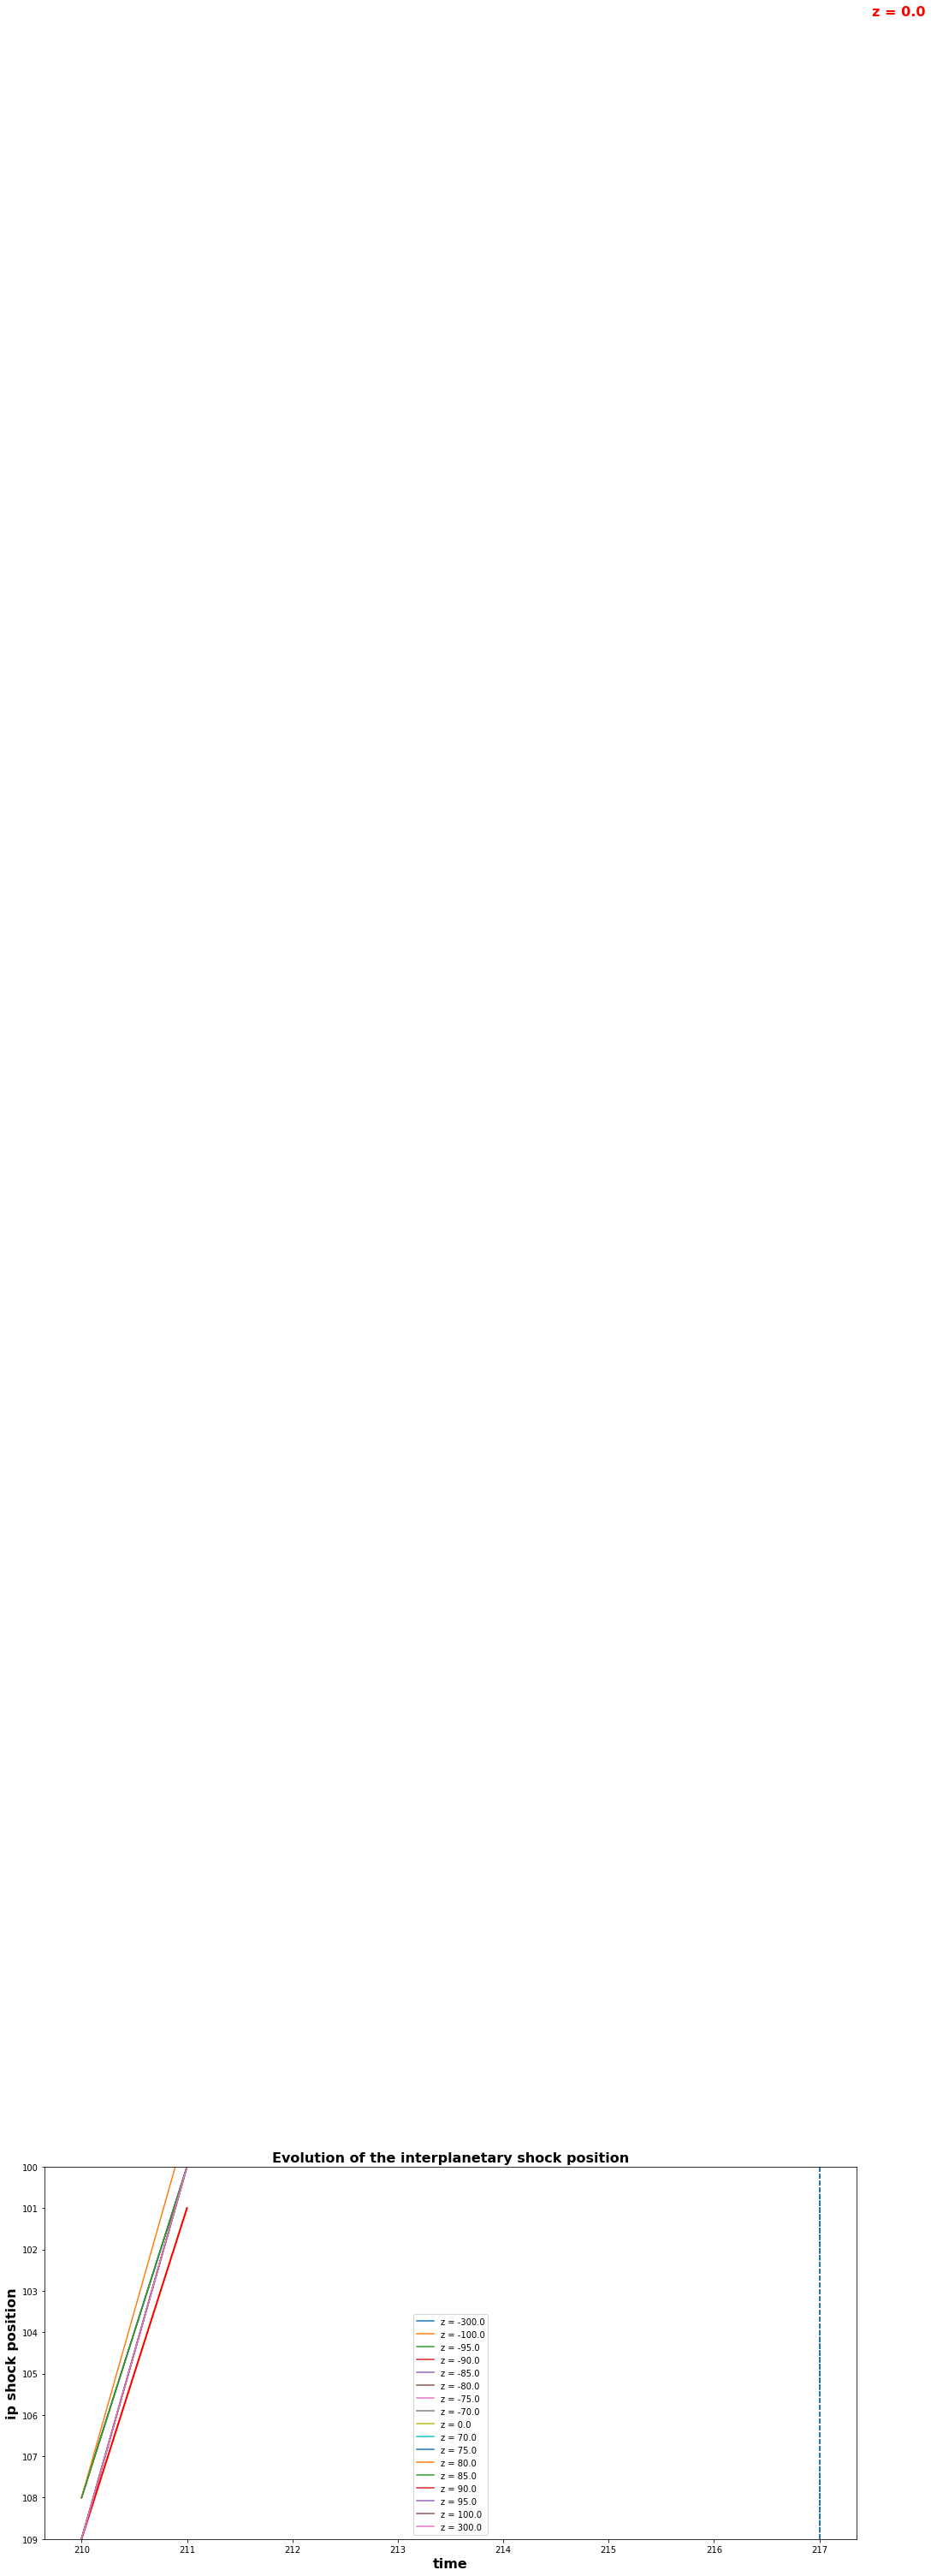

In [24]:
for z_slice in stored_data['00210']['Vx']['(xz) plane'].keys():

    if z_slice == 'z = -0.0':
        continue
        # plt.plot(t, pos, color='red', linewidth=2) 
        # plt.text(217.5,48, y_slice, color='red', weight='bold', fontsize='16')
 
    if verbose:
        print(z_slice)

    t = []
    pos = []

    for time in sorted(stored_data):

        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue
            
        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (z_slice == 'z = 0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = Vx_xz[z_slice]
        Vy = Vy_xz[z_slice]
        Vz = Vz_xz[z_slice]
        
        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
        j = 0
        while absurdity['absurd']:
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break
 
        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break


    if z_slice == 'z = 80.0':
        t_fig_z = t[:-1]
        pos_fig_z = pos[:-1]


    plt.plot(t, pos, label=z_slice)
    plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
    plt.ylim([max(pos), min(pos)])
    plt.ylabel('ip shock position', weight='bold', fontsize='16')
    plt.xlabel('time', weight='bold', fontsize='16')
    plt.axvline(217, linestyle='--', )

    if z_slice == 'z = 0.0':
        plt.plot(t, pos, color='red', linewidth=2) 
        plt.text(217.5,48, z_slice, color='red', weight='bold', fontsize='16')
        
plt.legend()
saving_title = "shock_tracking_xz"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Figures for publication

ValueError: max() arg is an empty sequence

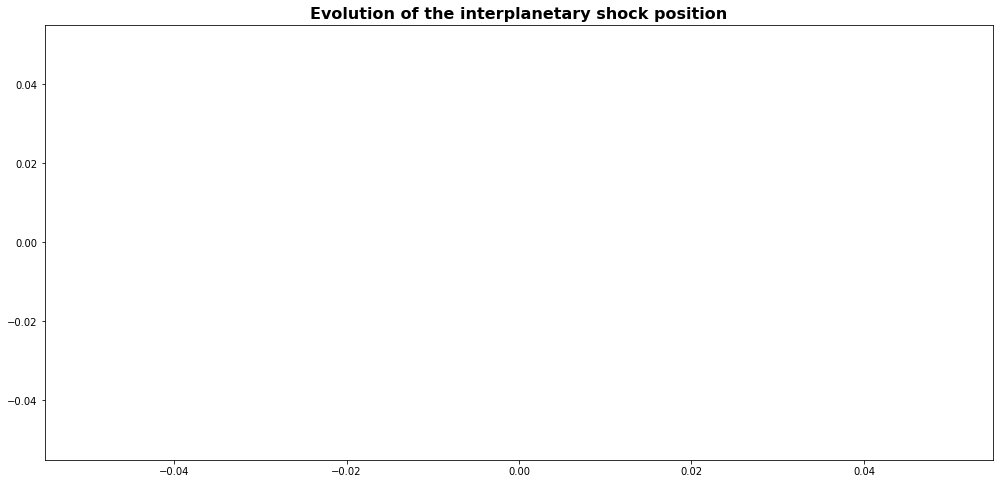

In [25]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

#fix weird detection due to IP shoc / bow shock being too close to each other
if t_collision:
    for i in range(0,len(t_fig_y0)):
        if t_fig_y0[i] < t_collision:
            pos_fig_y0[i] = pos_ref[i]
    
plt.plot(t_fig_y0 , pos_ref[0:len(t_fig_y0)]    , label='ip shock outside magnetosheath'
         , color = "darkcyan", linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_fig_y0), min(pos_fig_y0)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(210.5,108, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=16)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(216.65,100, 'ip shock reaches magnetopause', color='darkblue', fontsize=16)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty_bs_to_mp"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
'''''''''''''''''''''''
Figure for publication
'''''''''''''''''''''''

plt.plot(t_ref    , pos_ref    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , pos_fig_y0 , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , pos_fig_y  , label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , pos_fig_z  , label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='crimson')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='crimson', fontsize=14)
plt.axvline(220, linestyle='--', color='darkblue')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='darkblue', fontsize=14)
plt.legend(fontsize=14)
saving_title = "shock_tracking_pretty"
plt.savefig(dropbox_dir + '/' + saving_title + run_name + ".png",
            transparent=True, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
plt.plot(t_ref    , 0*np.array(t_ref)    , label='ip shock outside magnetosheath', linewidth=2.0)
plt.plot(t_fig_y0 , np.array(pos_fig_y0) - np.array(pos_ref)[0:len(pos_fig_y0)] , label='ip shock in (xy) plane, at y = 0 di', linewidth=2.0, color='red')
plt.plot(t_fig_y  , np.array(pos_fig_y)  - np.array(pos_ref), label='ip shock in (xy) plane, at y = 90 di', linewidth=2.0)
plt.plot(t_fig_z  , np.array(pos_fig_z)  - np.array(pos_ref)[0:len(pos_fig_z)], label='ip shock in (xz) plane, at z = 80 di', linewidth=2.0)
plt.title(f'Evolution of the interplanetary shock position', weight='bold', fontsize='16')
plt.ylim([max(pos_ref), min(pos_ref)])
plt.ylabel('ip shock position (di)', weight='bold', fontsize='16')
plt.xlabel(r'time $\Omega_{ci}^-1$', weight='bold', fontsize='16')
plt.axvline(216.5, linestyle='--', color='purple')
plt.text(216.75,-82, 'ip shock / bow shock collision at the subsolar point', color='purple', fontsize=14)
plt.axvline(220, linestyle='--', color='purple')
plt.text(220.25,33, 'ip shock reaches magnetopause', color='purple', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Test 

In [ ]:
'''''''''''''''''''''''
Check the ip shock detection
'''''''''''''''''''''''

verbose = False
rcParams["figure.figsize"] = [12,3]

# dummy_time:
time = '00210'

list_data_y = stored_data[time]['Vx']['(xy) plane']
# list_data_y = ['y = -0.0']

for str_y in list_data_y:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xy = stored_data[time]['Vx']['(xy) plane']
        Vy_xy = stored_data[time]['Vy']['(xy) plane']
        Vz_xy = stored_data[time]['Vz']['(xy) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None
        if (str_y == 'y = -0.0') and (int(time) > 216):
            info = 'slow'
        else:
            info = None

        Vx = np.array(Vx_xy[str_y])
        Vy = np.array(Vy_xy[str_y])
        Vz = np.array(Vz_xy[str_y])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_y}, shock at {x_is}: ABSURD')
#             plt.show()
                        
            test = absurdity['test']
            print(x[test])
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            
#             def debug():
#                 set_trace()
#                 absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
#                 return

#             if time=='00217':
#                 debug()

            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose, info=info)
            j = j+1
            if j==6:
                pos[-1]=np.nan
#                 break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
              pass
#             break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_y}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        ax.set_xlim([108, 0])
        plt.show()

list_data_z = stored_data[time]['Vx']['(xz) plane']

for str_z in list_data_z:

    t = []
    pos = []
                              
    for time in sorted(stored_data):
        
        if verbose:
            print(f'time = {time}')

        if not(time.isnumeric()):
            continue

        Vx_xz = stored_data[time]['Vx']['(xz) plane']
        Vy_xz = stored_data[time]['Vy']['(xz) plane']
        Vz_xz = stored_data[time]['Vz']['(xz) plane']

        if time=='00210':
            first_estimation = 115
        else:
            first_estimation = None

        Vx = np.array(Vx_xz[str_z])
        Vy = np.array(Vy_xz[str_z])
        Vz = np.array(Vz_xz[str_z])

        V = (Vx, Vy, Vz)

        x_is =  simplified_find_ip_shock(V, verbose=verbose)
        t.extend([int(time)])
        pos.extend([x_is])

        if verbose:
            print(f'first try x_is = {x_is}')    

        absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose=verbose, info=info)
        j = 0
        while absurdity['absurd']:
            
#             v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)
#             plt.axvline(x_is, color='blue')
#             plt.plot(x, v_slice)
#             plt.plot(x, np.gradient(v_slice))
#             plt.xlim([-100, 250])
#             plt.ylim([-5, 2*np.nanmean(v_slice)])
#             plt.title(f'time {time}, at {str_z}, shock at {x_is}: ABSURD')
#             plt.show()            
            
            test = absurdity['test']
            x_is =  simplified_find_ip_shock(V, test=test, verbose=verbose)
            pos[-1] = x_is
            absurdity = simplified_check_for_absurdities(pos, V, first_estimation, verbose)
            j = j+1
            if j==6:
                pos[-1]=np.nan
                break

        if (pos[-1]==-100 or np.isnan(pos[-1])):
            break

        v_slice = np.sqrt(Vx**2 + Vy**2 +Vz**2)

        plt.axvline(x_is, color='blue')
        plt.plot(x, v_slice)
        plt.plot(x, np.gradient(v_slice))
        plt.xlim([-100, 250])
        plt.ylim([-5, 2*np.nanmean(v_slice)])
        plt.title(f'time {time}, at {str_z}, shock at {x_is}')
        ax = plt.gca()
        ax.invert_xaxis()
        plt.show()


In [ ]:
time